In [1]:
import json
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from dateutil import relativedelta
from datetime import datetime
import tqdm
from src.models.MatchingType import MatchingType
from scipy import stats

In [3]:
con = sqlite3.connect('../data/interim/articles_with_author_mapping.db')
cur = con.cursor()

In [4]:
def get_abbreviations_with_names():
    cur.execute("select id, name, abbreviation, matching_certainty from unmapped_authors where matching_type = ? or matching_type = ?", (MatchingType.FUZZY_MATCH.name, MatchingType.DIRECT_MATCH.name))
    rows = cur.fetchall()
    authors = pd.DataFrame(columns=["id", "name", "abbreviation", "certainty"], data=rows)
    authors.set_index("id", inplace=True)
    return authors

authors = get_abbreviations_with_names()

In [5]:
# set certainty of a row to the average certainty over all rows with same name and abbreviation, ignore nan values
mean_certainty = authors.groupby(["name", "abbreviation"])["certainty"].transform(lambda x: np.nanmean(x))
authors["certainty"] = mean_certainty

In [6]:
authors["name_pointing_to_abbreviation_count"] = authors.groupby(["name", "abbreviation"])["name"].transform("count")
authors["abbreviation_pointing_to_name_count"] = authors.groupby(["name", "abbreviation"])["abbreviation"].transform("count")

In [7]:
# drop duplicates based on name, abbreviation, certainty. I can drop them because ..._count saved the count
authors.drop_duplicates(subset=["name", "abbreviation", "certainty"], inplace=True)

In [8]:
# set the share that the name has of all names that point to that abbreviation
authors_with_name_pointing_to_abbreviation_sum =  authors.groupby(["abbreviation"]).agg(names_pointing_to_abbreviation_sum=("name_pointing_to_abbreviation_count", "sum")).reset_index()
authors = pd.merge(authors, authors_with_name_pointing_to_abbreviation_sum, on="abbreviation")
authors["name_pointing_to_abbreviation_share"] = authors["name_pointing_to_abbreviation_count"] / authors["names_pointing_to_abbreviation_sum"]

In [9]:
# set the share that the abbreviation has of all abbreviations that point to that name
authors_with_abbreviation_pointing_to_name_sum = authors.groupby(["name"]).agg(abbreviations_pointing_to_name_sum=("abbreviation_pointing_to_name_count", "sum")).reset_index()
authors = pd.merge(authors, authors_with_abbreviation_pointing_to_name_sum, on="name")
authors["abbreviation_pointing_to_name_share"] = authors["abbreviation_pointing_to_name_count"] / authors["abbreviations_pointing_to_name_sum"]

In [10]:
# calculate a final score for the weighted edge between name and abbreviation
authors["score"] = authors["certainty"] + authors["name_pointing_to_abbreviation_share"] + authors["abbreviation_pointing_to_name_share"]

In [11]:
# TODO: change this, depending on what scores should be included
authors["score"] = authors["certainty"]

In [10]:
# reduce the problem space to a bipartite graph, assigning all (name, abbreviation) pairs that are not connected to the graph as final/solved
# add pairs to final mapping where abbreviation_pointing_to_name_count == 1 or name_pointing_to_abbreviation_count == 1 and remove those from the authors 
#one_to_one_mappings = authors[(authors["abbreviations_pointing_to_name_sum"] == 1) & (authors["names_pointing_to_abbreviation_sum"] == 1)]
#final_mapping = pd.concat([final_mapping, one_to_one_mappings[["name", "abbreviation"]]], ignore_index=True)

#authors = authors[(authors["abbreviations_pointing_to_name_sum"] != 1) | (authors["names_pointing_to_abbreviation_sum"] != 1)]

In [12]:
# remove self referencing nodes
authors = authors[authors["name"].str.lower() != authors["abbreviation"].str.lower()]

In [13]:
G = nx.Graph()
G.clear()
author_list = list(authors["name"].unique())
abbr_list = list(authors[authors["name"].isin(author_list)]["abbreviation"].unique())
G.add_nodes_from(author_list, bipartite=0)
G.add_nodes_from(abbr_list, bipartite=1)
dummy_nodes = [f"{name}_dummy" for name in author_list]
G.add_nodes_from(dummy_nodes, bipartite=1)

edges = []
for index, row in authors[authors["name"].isin(author_list) & authors["abbreviation"].isin(abbr_list)].iterrows():
    G.add_edges_from([(row["name"], row["abbreviation"])], weight=round(row["score"],2) * -1)

for name in author_list:
    G.add_edges_from([(name, f"{name}_dummy")], weight=0)


In [14]:
new_edges = nx.bipartite.minimum_weight_full_matching(G, top_nodes=list(authors["name"].unique()), weight="weight")
g_new = nx.Graph()
g_new.clear()
g_new.add_nodes_from(author_list, bipartite=0)
g_new.add_nodes_from(abbr_list, bipartite=1)
g_new.add_edges_from(new_edges.items())

In [15]:
g_new.edges

EdgeView([('Kai-Uwe Brandt', 'kub'), ('Nadja Topfstedt', 'jap'), ('Andreas Tappert', 'at'), ('Annett Riedel', 'ar'), ('Angelika Raulien', 'Angelika Raulien_dummy'), ('Andrea Richter', 'Andrea Richter_dummy'), ('Antje Henselin-Rudolph', 'ahr'), ('Heike Liesaus', 'Heike Liesaus_dummy'), ('Juliane Streich', 'Juliane Streich_dummy'), ('Janina Fleischer', 'jaf'), ('Lisa Berins', 'Lisa Berins_dummy'), ('Lisa Schliep', 'lis'), ('Nico Fliegner', 'nf'), ('Frank Pfütze', 'pfü'), ('Werner Kopfmüller', 'Werner Kopfmüller_dummy'), ('Kendra Reinhardt', 'ka'), ('Karoline Maria Keybe', 'mey'), ('Karin Rieck', 'karin'), ('Karin Tamcke', 'Karin Tamcke_dummy'), ('Klaus Staeubert', 'ks'), ('Kay Würker', 'Kay Würker_dummy'), ('Kathrin Kabelitz', 'Kathrin Kabelitz_dummy'), ('Kai Kollenberg', 'kol'), ('Nikos Natsidis', 'nn'), ('Matthias Puppe', 'mpu'), ('Robert Nößler', 'nöß'), ('Ditmar Wohlgemuth', 'dom'), ('Claudia Carell-Domröse', 'Claudia Carell-Domröse_dummy'), ('Dominik Bath', 'Dominik Bath_dummy'), ('

In [16]:
print(f"new graph has {len(g_new.nodes)} nodes and {len(g_new.edges)} edges")

new graph has 384 nodes and 182 edges


In [17]:
# transform graph to dataframe author_mapping with columns name and abbreviation
author_mapping = pd.DataFrame(columns=["name", "abbreviation"], data=g_new.edges)
author_mapping = author_mapping.astype(str)

print(f"author_mapping has {author_mapping.shape[0]} rows")


# remove all abbreviations that contain "dummy" in their name
author_mapping = author_mapping[~author_mapping["abbreviation"].str.contains("dummy")]
# print shape
print(f"author_mapping has {author_mapping.shape[0]} rows")

author_mapping has 182 rows
author_mapping has 142 rows


### In the following there are some analyses covering the correctness of the approach

In [18]:
# test if there is an authors that was mapped to an abbreviation that exceeds the authors name writing time by more than 6 months in the time before or after
# Note: does not check for authors that exceed abbreviation time. Assumption: an abbreviation can be assigned to an author also later
count = 0
author_abbreviation_pairs_with_lifespan_difference = []
for index, row in author_mapping.iterrows():
    author = row["name"]
    abbreviation = row["abbreviation"]
    author_like = f"%{json.dumps(author)}%"
    abbr_like = f"%{json.dumps(abbreviation)}%"
    try:
        first_article_author = cur.execute(f"SELECT MIN(published_at) FROM articles where author_array like ?", (author_like,)).fetchone()[0]
        first_article_abbr = cur.execute(f"SELECT MIN(published_at) FROM articles where author_array like ?", (abbr_like,)).fetchone()[0]
        first_article_author = datetime.strptime(first_article_author, "%Y-%m-%dT%H:%M:%S+00:00")
        first_article_abbr = datetime.strptime(first_article_abbr, "%Y-%m-%dT%H:%M:%S+00:00")

        # check if first_article_abbr is six month ahead of first_article_author
        if first_article_abbr < first_article_author - relativedelta.relativedelta(months=12):
            print(f"author: {author}, first_article_author: {first_article_author}, abbreviation: {abbreviation}, first_article_abbr: {first_article_abbr}")
            count += 1
            author_abbreviation_pairs_with_lifespan_difference.append({"author": author, "abbreviation": abbreviation})

        last_article_author = cur.execute(f"SELECT MAX(published_at) FROM articles where author_array like ?", (author_like,)).fetchone()[0]
        last_article_abbr = cur.execute(f"SELECT MAX(published_at) FROM articles where author_array like ?", (abbr_like,)).fetchone()[0]
        last_article_author = datetime.strptime(last_article_author, "%Y-%m-%dT%H:%M:%S+00:00")
        last_article_abbr = datetime.strptime(last_article_abbr, "%Y-%m-%dT%H:%M:%S+00:00")

        # check if last_article_abbr is six month behind of last_article_author
        if last_article_abbr > last_article_author + relativedelta.relativedelta(months=12):
            print(f"author: {author}, last_article_author: {last_article_author}, abbreviation: {abbreviation}, last_article_abbr: {last_article_abbr}")
            count += 1
            author_abbreviation_pairs_with_lifespan_difference.append({"author": author, "abbreviation": abbreviation})
    except TypeError:
        print(f"author: {author}, abbreviation: {abbreviation}")
        continue

print(f"there are {count} authors that were mapped to an abbreviation that exceeds the authors name writing time by more than 12 months in the time before or after")

author: Lisa Schliep, first_article_author: 2015-05-14 21:59:00, abbreviation: lis, first_article_abbr: 2010-01-07 15:35:14
author: Manuel Niemann, first_article_author: 2016-06-30 07:10:00, abbreviation: mi, first_article_abbr: 2010-01-27 17:55:42
author: Christine Gräfe, last_article_author: 2013-07-21 13:37:00, abbreviation: cg, last_article_abbr: 2021-07-18 08:30:06
author: Kathleen Retzar, first_article_author: 2020-10-02 12:36:18, abbreviation: kr, first_article_abbr: 2010-02-14 13:54:25
author: Jörg Reuter, last_article_author: 2020-04-07 07:12:00, abbreviation: jr, last_article_abbr: 2021-12-13 18:56:42
author: Jörg Wolf, first_article_author: 2011-05-03 19:14:21, abbreviation: jw, first_article_abbr: 2010-04-01 08:07:16
author: Thomas Steingen, last_article_author: 2018-04-20 08:00:00, abbreviation: ts, last_article_abbr: 2021-12-28 17:01:00
author: Christiane Lösch, last_article_author: 2016-10-06 07:56:00, abbreviation: chl, last_article_abbr: 2017-10-06 10:16:00
author: ter

We can conclude that we need a mapping that takes into account the authors' lifespans. Abbreviations can be used for more than one author. Furthermore, we need to penalize abbr-author mappings where the abbreviation has a much longer or shorter lifespan.

Further, we notice that there are abbreviations that do not have an associated author. E.g. "joka", does not have any good fit.

In [18]:
for row in tqdm.tqdm([row for _, row in author_mapping.iterrows()]):
    abbr_authors = []
    abbr = row["abbreviation"]
    mapped_author = row["name"]
    abbr_neighbours = list(G.neighbors(abbr))
    for author in abbr_neighbours:
        author_like = f"%{json.dumps(author)}%"
        rows = cur.execute('select ar.published_at from articles ar where ar.author_array like ?', (author_like,)).fetchall()
        type = "mapped name" if author == mapped_author else "name"
        abbr_authors.extend([{"author": author, "type": type, "published_at": row[0]} for row in rows])

    
    abbr_like = f"%{json.dumps(abbr)}%"
    rows = cur.execute('select ar.published_at from articles ar where ar.author_array like ?', (abbr_like,)).fetchall()
    abbr_authors.extend([{"author": abbr, "type": "abbreviation", "published_at": row[0]} for row in rows])

    abbr_authors = pd.DataFrame(columns=["author", "type", "published_at"], data=abbr_authors)

    # aggregate by quarter of the year
    abbr_authors['published_at'] = pd.to_datetime(abbr_authors['published_at'])
    abbr_authors['quarter'] = abbr_authors['published_at'].dt.quarter
    abbr_authors['year'] = abbr_authors['published_at'].dt.year
    abbr_authors['year_quarter'] = abbr_authors['year'].astype(str) + "/" + abbr_authors['quarter'].astype(str)
    #abbr_authors['year_semester'] = abbr_authors['year'].astype(str) + "/" + abbr_authors['quarter'].apply(lambda x: 1 if x <= 2 else 2).astype(str)
    abbr_authors = abbr_authors.groupby(['year_quarter', 'author', 'type']).count()['published_at'].reset_index()
    # rename published at to count
    abbr_authors = abbr_authors.rename(columns={"published_at": "count"})
    
    # fill year_quarter gaps
    year_quarters = abbr_authors['year_quarter'].drop_duplicates()
    # get min and max year
    min_year = int(min(year_quarters).split("/")[0])
    max_year = int(max(year_quarters).split("/")[0])
    # get for min_year min quarter and for max_year max quarter
    min_quarter = int(min([year_quarter.split("/")[1] for year_quarter in year_quarters if year_quarter.split("/")[0] == str(min_year)]))
    max_quarter = int(max([year_quarter.split("/")[1] for year_quarter in year_quarters if year_quarter.split("/")[0] == str(max_year)]))
    # create all year_quarters
    year_quarters = [str(year) + "/" + str(quarter) for year in range(min_year, max_year + 1) for quarter in range(1, 5)]
        
    # for each author: if there is no entry for a unique combination of 'year_quarter', add it with count np.nan
    index = pd.MultiIndex.from_product([year_quarters, abbr_authors['author'].unique()], names=['year_quarter', 'author'])
    
    # Reindex the DataFrame with the MultiIndex to fill in missing combinations with NaN
    abbr_authors = abbr_authors.set_index(['year_quarter', 'author']).reindex(index, fill_value=None).reset_index()
    
    # set type for each author to first type of that author
    abbr_authors['type'] = abbr_authors.groupby('author')['type'].transform('first')
    
    # sort by year_quarter and type
    abbr_authors = abbr_authors.sort_values(by=['year_quarter', 'type'])
    
    directory = "author_abbreviation_pairs"

    if {"author": mapped_author, "abbreviation": abbr} in author_abbreviation_pairs_with_lifespan_difference:
        directory = "author_abbreviation_pairs_with_lifespan_difference"

    
    plt.cla()
    plt.clf()
    
    sns.lineplot(data=abbr_authors, x='year_quarter', y='count', hue='author', style='type', errorbar=None, linewidth=2.5)
    # set y title to article count
    plt.ylabel("article count")
    plt.xlabel("year/quarter")
    sns.set(rc={'figure.figsize':(14,10)})
    plt.xticks(rotation=-75)
    # set ticks to every 4th
    plt.xticks(np.arange(0, len(abbr_authors['year_quarter'].unique()), 4))
    plt.tight_layout()
    plt.title(f'Article count of abbreviation {abbr}, associated authors and mapped author {mapped_author}')
    plt.savefig(f'../reports/figures/{directory}/articles_written_by_abbreviation_{abbr}_and_mapped_author_{"_".join(mapped_author.split(" "))}_and_associated_authors.png',bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()
  

  0%|          | 0/142 [00:14<?, ?it/s]


KeyboardInterrupt: 

### the following cell computes pearson correlation coef between the mapped name and the abbreviation

 49%|████▊     | 69/142 [35:28<33:57, 27.91s/it]  

not enough data points for author Michael Graul and abbreviation haeg


 53%|█████▎    | 75/142 [38:22<31:46, 28.46s/it]

not enough data points for author Michael Frömmert and abbreviation mf


 68%|██████▊   | 96/142 [48:51<22:45, 29.69s/it]

not enough data points for author Ulf Heise and abbreviation uh


 87%|████████▋ | 124/142 [1:02:17<08:41, 29.00s/it]

not enough data points for author Nadine Marquardt and abbreviation nqq


 91%|█████████ | 129/142 [1:04:35<06:02, 27.85s/it]

not enough data points for author Stephanie Jankowski and abbreviation thiko


100%|██████████| 142/142 [1:10:39<00:00, 29.86s/it]


<Axes: xlabel='n_data_points', ylabel='pearson_coef'>

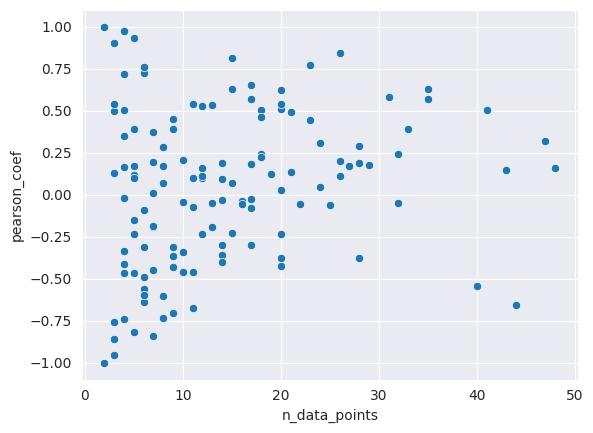

In [19]:
pearson_coef_sum = 0
pearson_p_value_sum = 0

correlation_df = pd.DataFrame(columns=["name", "abbreviation", "pearson_coef", "p_value", "n_data_points"])

for row in tqdm.tqdm([row for _, row in author_mapping.iterrows()]):
    abbr_authors = []
    abbr = row["abbreviation"]
    mapped_author = row["name"]
    author_like = f"%{json.dumps(mapped_author)}%"
    rows = cur.execute('select ar.published_at from articles ar where ar.author_array like ?', (author_like,)).fetchall()
    abbr_authors.extend([{"author": mapped_author, "type": "mapped name", "published_at": row[0]} for row in rows])

    
    abbr_like = f"%{json.dumps(abbr)}%"
    rows = cur.execute('select ar.published_at from articles ar where ar.author_array like ?', (abbr_like,)).fetchall()
    abbr_authors.extend([{"author": abbr, "type": "abbreviation", "published_at": row[0]} for row in rows])

    abbr_authors = pd.DataFrame(columns=["author", "type", "published_at"], data=abbr_authors)

    # aggregate by quarter of the year
    abbr_authors['published_at'] = pd.to_datetime(abbr_authors['published_at'])
    abbr_authors['quarter'] = abbr_authors['published_at'].dt.quarter
    abbr_authors['year'] = abbr_authors['published_at'].dt.year
    abbr_authors['year_quarter'] = abbr_authors['year'].astype(str) + "/" + abbr_authors['quarter'].astype(str)
    #abbr_authors['year_semester'] = abbr_authors['year'].astype(str) + "/" + abbr_authors['quarter'].apply(lambda x: 1 if x <= 2 else 2).astype(str)
    abbr_authors = abbr_authors.groupby(['year_quarter', 'author', 'type']).count()['published_at'].reset_index()
    # rename published at to count
    abbr_authors = abbr_authors.rename(columns={"published_at": "count"})
    
    # fill year_quarter gaps
    year_quarters = abbr_authors['year_quarter'].drop_duplicates()
    # get min and max year
    min_year = int(min(year_quarters).split("/")[0])
    max_year = int(max(year_quarters).split("/")[0])
    # get for min_year min quarter and for max_year max quarter
    min_quarter = int(min([year_quarter.split("/")[1] for year_quarter in year_quarters if year_quarter.split("/")[0] == str(min_year)]))
    max_quarter = int(max([year_quarter.split("/")[1] for year_quarter in year_quarters if year_quarter.split("/")[0] == str(max_year)]))
    # create all year_quarters
    year_quarters = [str(year) + "/" + str(quarter) for year in range(min_year, max_year + 1) for quarter in range(1, 5)]
        
    # for each author: if there is no entry for a unique combination of 'year_quarter', add it with count np.nan
    index = pd.MultiIndex.from_product([year_quarters, abbr_authors['author'].unique()], names=['year_quarter', 'author'])
    
    # Reindex the DataFrame with the MultiIndex to fill in missing combinations with NaN
    abbr_authors = abbr_authors.set_index(['year_quarter', 'author']).reindex(index, fill_value=None).reset_index()
    
    # set type for each author to first type of that author
    abbr_authors['type'] = abbr_authors.groupby('author')['type'].transform('first')
    
    # sort by year_quarter and type
    abbr_authors = abbr_authors.sort_values(by=['year_quarter', 'type'])
    
    # calculate pearson correlation coefficient
    # Extract relevant subsets from the DataFrame
    mapped_name_counts = abbr_authors[abbr_authors["type"] == "mapped name"][['year_quarter', 'count']]
    abbreviation_counts = abbr_authors[abbr_authors["type"] == "abbreviation"][['year_quarter', 'count']]
    
    # Merge the two DataFrames on the 'year_quarter' column
    merged_df = pd.merge(mapped_name_counts, abbreviation_counts, on='year_quarter', suffixes=('_mapped_name', '_abbreviation'))
    
    # Drop NaN values
    merged_df = merged_df.dropna()
    
    # Calculate Pearson correlation coefficient and p-value
    # test if df is long enough
    if merged_df.shape[0] < 2:
        print(f"not enough data points for author {mapped_author} and abbreviation {abbr}")
        continue
    correlation_coefficient, p_value = stats.pearsonr(merged_df['count_mapped_name'], merged_df['count_abbreviation'])
    # add to correlation_df
    correlation_df.loc[len(correlation_df)] = [mapped_author, abbr, correlation_coefficient, p_value, merged_df.shape[0]]
    
    
# scatterplot of pearson correlation coefficient for n_data_points
sns.scatterplot(data=correlation_df, x="n_data_points", y="pearson_coef")

In [20]:
# calculate average coef and p value
print(f"average pearson coefficient: {correlation_df['pearson_coef'].mean()}")
print(f"average p value: {correlation_df['p_value'].mean()}")

average pearson coefficient: 0.07352442942665656
average p value: 0.41742984665175376


<Figure size 1400x1000 with 0 Axes>

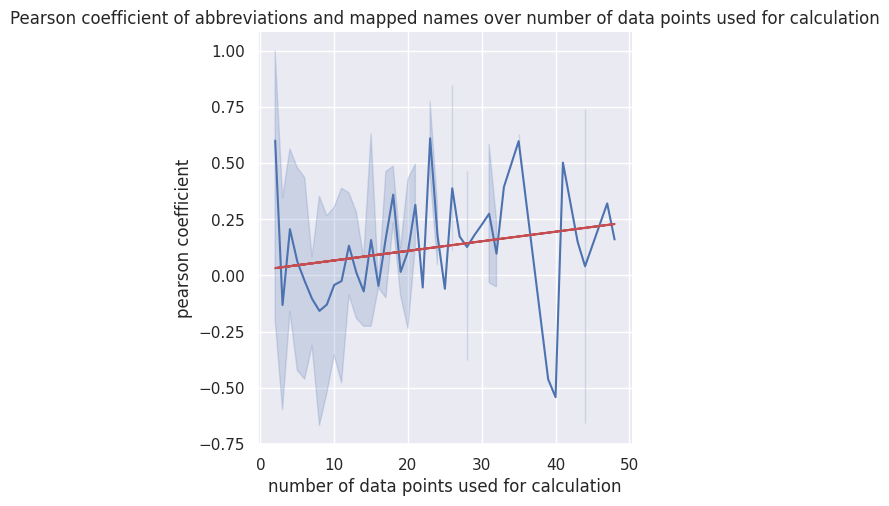

In [60]:
plt.cla()
plt.clf()

sns.relplot(kind='line', data=correlation_df, x="n_data_points", y="pearson_coef")
# run regression
slope, intercept, r_value, p_value, std_err = stats.linregress(correlation_df["n_data_points"], correlation_df["pearson_coef"])
# plot regression line
plt.plot(correlation_df["n_data_points"], intercept + slope*correlation_df["n_data_points"], 'r', label='fitted line')
# set y title to article count
plt.ylabel("pearson coefficient")
plt.xlabel("number of data points used for calculation")
sns.set(rc={'figure.figsize':(14,10)})
plt.tight_layout()
plt.title(f'Pearson coefficient of abbreviations and mapped names over number of data points used for calculation')
plt.savefig(f'../reports/figures/pearson_coefficient_of_abbreviations_and_mapped_names_over_number_of_data_points_used_for_calculation.png',bbox_inches='tight',dpi=300)
plt.show()


Mind the fact that seaborn lineplot connects non-neighbouring points. If more correct view is needed, choose scatterplot. See here for further infos: https://stackoverflow.com/questions/52098537/avoid-plotting-missing-values-on-a-line-plot


Takeaways:
* Author entities can have different names (compare Inge Engelhardt and Inge-Dore Engelhardt in "articles_written_by_abbreviation_ie_and_mapped_author_Inge_Engelhardt_and_associated_authors"
  * an obvious szenario is that the author got married and changed their name
* there are only few mappings where the abbreviation and the name share a similar article count distribution 
  * one good example is: articles_written_by_abbreviation_lyn_and_mapped_author_Evelyn_ter_Vehn_and_associated_authors
  * one example for a more or less good similarity is: articles_written_by_abbreviation_hgw_and_mapped_author_Hanna_Gerwig_and_associated_authors
  * one example for a match but with close to no similarity is: articles_written_by_abbreviation_krysta_and_mapped_author_Krysta_Brown_and_associated_authors 
  * a good example for the randomness in using the abbreviation or the name is: articles_written_by_abbreviation_mpu_and_mapped_author_Matthias_Puppe_and_associated_authors
  * TODO: Calculate the similarity of abbr and mapped name distribution and all other names so that we can determine if the mapped
    author is closer to the distribution of the abbreviation than all the other none mapped names
  * TODO: Conclusion  

Note:
If an abbreviation or name has only written articles in one quarter and thus only one data point, it won't get displayed by seaborn


In [40]:
print(f"new graph has {len(g_new.nodes)} nodes and {len(g_new.edges)} edges")

new graph has 387 nodes and 183 edges


There are abbr nodes that were not matched with any author. That's why we have: edges * 2 < nodes.

In [41]:
# test that only abbrs are not in the matches nodes
for node in g_new.nodes:
    if g_new.degree(node) == 0 and node in author_list:
        print(f"author node {node} has no edges")
    elif g_new.degree(node) == 0 and node in abbr_list:
        print(f"abbreviation node {node} has no edges")

abbreviation node ast has no edges
abbreviation node at has no edges
abbreviation node ms has no edges
abbreviation node nie has no edges
abbreviation node mape has no edges
abbreviation node mot has no edges
abbreviation node mabe has no edges
abbreviation node beck has no edges
abbreviation node thomas has no edges
abbreviation node th has no edges
abbreviation node ter vehn has no edges
abbreviation node döring has no edges
abbreviation node isc has no edges
abbreviation node grätz has no edges
abbreviation node sag has no edges
abbreviation node nag has no edges
abbreviation node kreuz has no edges
abbreviation node dei has no edges
abbreviation node sie has no edges
abbreviation node iro has no edges
abbreviation node she has no edges


In [42]:
# list the abbreviations that were connected to the author that the edges with zero edges were pointing to
# so we can e.g. check if we need to enable multiple abbreviations for the same author
for node in g_new.nodes:
    if g_new.degree(node) == 0:
        # check the authors of the old graph that were pointing to this abbreviation
        old_neighbors = G.neighbors(node)
        for old_neighbor in old_neighbors:
            print(f"new neighbors of old abbr {node} node neighbors {old_neighbor} are {list(g_new.neighbors(old_neighbor))}")


new neighbors of old abbr ast node neighbors Andreas Tappert are ['art']
new neighbors of old abbr at node neighbors Andreas Tappert are ['art']
new neighbors of old abbr ms node neighbors Melanie Steitz are ['mes']
new neighbors of old abbr ms node neighbors Michael Strohmeyer are ['mey']
new neighbors of old abbr ms node neighbors Mathias Schönknecht are ['mhs']
new neighbors of old abbr nie node neighbors Nico Fliegner are ['nf']
new neighbors of old abbr mape node neighbors Matthias Puppe are ['mpu']
new neighbors of old abbr mot node neighbors Matthias Roth are ['mro']
new neighbors of old abbr mabe node neighbors Mathias Orbeck are ['mo']
new neighbors of old abbr mabe node neighbors Mario Beck are ['mario']
new neighbors of old abbr beck node neighbors Mathias Orbeck are ['mo']
new neighbors of old abbr beck node neighbors Mario Beck are ['mario']
new neighbors of old abbr thomas node neighbors Thomas Sparrer are ['tsa']
new neighbors of old abbr th node neighbors Thomas Haegele

From this we do see that some authors have several abbreviations
For example in an earlier analysis with no authors sorted out based on their article number: krysta brown has probably two abbreviations: "krysta" and "brown"

In [43]:
print(f"{(len(g_new.edges))} abbreviations were matched")
print(f"There are {len(g_new.nodes) - (len(g_new.edges) * 2)} abbreviations that were not matched")

183 abbreviations were matched
There are 21 abbreviations that were not matched


In [44]:
# print not matched abbreviations
print([node for node in g_new.nodes if g_new.degree(node) == 0])

['ast', 'at', 'ms', 'nie', 'mape', 'mot', 'mabe', 'beck', 'thomas', 'th', 'ter vehn', 'döring', 'isc', 'grätz', 'sag', 'nag', 'kreuz', 'dei', 'sie', 'iro', 'she']


In [45]:
# test if these abbreviations have only one edge in the old graph. If so, we can append them to that author.
# assumes that the names got assigned a more fitting abbreviation but these here do also belong to that name
unmatched_abbrs_with_only_one_edge = [node for node in g_new.nodes if g_new.degree(node) == 0 and len(list(G.neighbors(node))) == 1]
print(f"{len(unmatched_abbrs_with_only_one_edge)} abbreviations have only one edge in the old graph")

# list remaining abbreviations
remaining_abbrs = [node for node in g_new.nodes if g_new.degree(node) == 0 and len(list(G.neighbors(node))) > 1]
print(remaining_abbrs)

17 abbreviations have only one edge in the old graph
['ms', 'mabe', 'beck', 'nag']


We conclude, that most of the unmatched abbreviations were only connected to one author originally. That means that we can append them to that author because we know now that authors can have multiple abbreviations.